In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import rasterio

from tqdm import tqdm

from PIL import Image

import os
import glob

from matplotlib import pyplot as plt

In [27]:
data_directory = '/workspace/Data_share/'
tif_files = glob.glob(os.path.join(data_directory, '**', '*.tif'), recursive=True)
print(len(tif_files))

6012


In [47]:
ca_files = glob.glob(os.path.join('/workspace/Data_share/CA', '**', '*.tif'), recursive=True)
il_files = glob.glob(os.path.join('/workspace/Data_share/IL', '**', '*.tif'), recursive=True)
nd_files = glob.glob(os.path.join('/workspace/Data_share/ND', '**', '*.tif'), recursive=True)
ne_files = glob.glob(os.path.join('/workspace/Data_share/NE', '**', '*.tif'), recursive=True)

In [40]:
print(len(ca_files))
print(len(il_files))
print(len(nd_files))
print(len(ne_files))

2388
990
612
2022


In [56]:
with rasterio.open(il_files[0]) as r:
    print (r.meta)
    print(r.transform[0], r.transform[4])

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 800, 'height': 800, 'count': 1, 'crs': CRS.from_epsg(26916), 'transform': Affine(1.0, 0.0, 329001.6827999996,
       0.0, -1.0, 4533498.332599999)}
1.0 -1.0


## Get Statistics for all sub-directories

In [4]:
class ImageData(Dataset):
    
    def __init__(self, file_paths):
        super().__init__()
        self.file_paths = file_paths
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        
        # import
        file_path = self.file_paths[idx]        
        with rasterio.open(file_path, mode='r') as src:
            data = src.read().astype('float32')

        return data


## Convert all elevation into relative elevation

In [9]:
for tif_file in tqdm(tif_files, total=len(tif_files)):
    with rasterio.open(tif_file, 'r') as src:
        kwrds = src.profile
        data = src.read(1)

        min_value = data.min()
        
        # subtract minimum value from the raster
        new_data = data - min_value

    kwrds.update(
        dtype=rasterio.float32,
        nodata=None
    )
    
    with rasterio.open(tif_file, 'w', **kwrds) as dst:
        dst.write(new_data, 1)


100%|█████████████████████████████████████| 612/612 [00:35<00:00, 17.26it/s]


## Get mean and standard deviation for all chosen image chips

In [34]:
initial_chips = ca_files + ne_files + il_files

In [35]:
all_chips = initial_chips
image_dataset = ImageData(all_chips)
image_loader = DataLoader(image_dataset, 
                      batch_size  = 1, 
                      shuffle     = False, 
                      num_workers = 0)

psum    = torch.tensor([0.0])
psum_sq = torch.tensor([0.0])
avg_elevation = []
min_elevation = []
max_elevation = []
elevation_range = []

# loop through images
for inputs in tqdm(image_loader):
    if inputs.max() > 100000 or inputs.min() < 0:
        continue
    psum += inputs.sum()
    psum_sq += (inputs ** 2).sum()

    avg_elevation.append(inputs.mean())
    min_elevation.append(inputs.mean())
    max_elevation.append(inputs.max())
    elevation_range.append(inputs.max() - inputs.min())
    
# pixel count
count = len(tif_files) * 800 * 800

# mean and STD
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('Training data stats:')
print('- mean: {:.4f}'.format(total_mean.item()))
print('- std:  {:.4f}'.format(total_std.item()))

avg_elevation = torch.stack(avg_elevation, dim=0)
min_elevation = torch.stack(min_elevation, dim=0)
max_elevation = torch.stack(max_elevation, dim=0)
elevation_range = torch.stack(elevation_range, dim=0)

100%|███████████████████████████████████| 5400/5400 [01:49<00:00, 49.20it/s]

Training data stats:
- mean: 6.6385
- std:  10.1845


Text(0.5, 0, 'Bins')

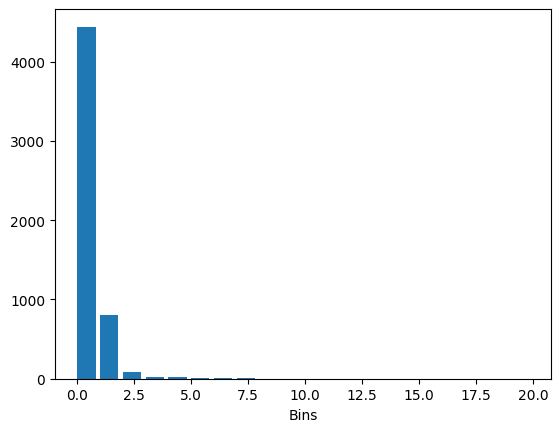

In [36]:
hist = torch.histc(avg_elevation, bins = 20, min = 0, max = avg_elevation.max())

bins = 20
x = range(bins)
plt.bar(x, hist, align='edge')
plt.xlabel('Bins')


In [38]:
all_chips = nd_files
image_dataset = ImageData(all_chips)
image_loader = DataLoader(image_dataset, 
                      batch_size  = 1, 
                      shuffle     = False, 
                      num_workers = 0)

psum    = torch.tensor([0.0])
psum_sq = torch.tensor([0.0])
avg_elevation = []
min_elevation = []
max_elevation = []
elevation_range = []

# loop through images
for inputs in tqdm(image_loader):
    if inputs.max() > 100000 or inputs.min() < 0:
        continue
    psum += inputs.sum()
    psum_sq += (inputs ** 2).sum()

    avg_elevation.append(inputs.mean())
    min_elevation.append(inputs.mean())
    max_elevation.append(inputs.max())
    elevation_range.append(inputs.max() - inputs.min())
    
# pixel count
count = len(tif_files) * 800 * 800

# mean and STD
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('Training data stats:')
print('- mean: {:.4f}'.format(total_mean.item()))
print('- std:  {:.4f}'.format(total_std.item()))

avg_elevation = torch.stack(avg_elevation, dim=0)
min_elevation = torch.stack(min_elevation, dim=0)
max_elevation = torch.stack(max_elevation, dim=0)
elevation_range = torch.stack(elevation_range, dim=0)

100%|█████████████████████████████████████| 612/612 [00:12<00:00, 49.07it/s]

Training data stats:
- mean: 0.7294
- std:  9.3929


Text(0.5, 0, 'Bins')

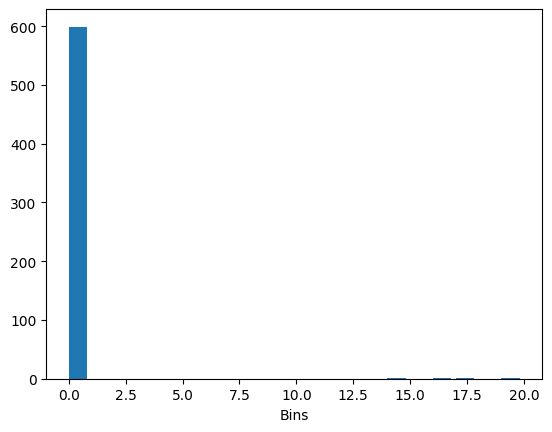

In [39]:
hist = torch.histc(avg_elevation, bins = 20, min = 0, max = avg_elevation.max())

bins = 20
x = range(bins)
plt.bar(x, hist, align='edge')
plt.xlabel('Bins')
